In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paths (relative to project root)
train_path = "./data/train_data_v2.csv"
test_path = "./data/test_data_v2.csv"
sample_path = "./sample/sample.csv"


In [2]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()


Train shape: (14731, 22)
Test shape: (6599, 21)


,HomePage,HomePage_Duration,LandingPage,LandingPage_Duration,ProductDescriptionPage,ProductDescriptionPage_Duration,GoogleMetric:Bounce Rates,GoogleMetric:Exit Rates,GoogleMetric:Page Values,SeasonalPurchase,...,SearchEngine,Zone,Type of Traffic,CustomerType,Gender,Cookies Setting,Education,Marital Status,WeekendPurchase,Made_Purchase
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,...,1.0,9.0,3.0,Returning_Visitor,Not Specified,Deny,Not Specified,Other,0.0,False
1,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,...,2.0,2.0,4.0,Returning_Visitor,Female,Deny,Others,Married,0.0,False
2,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,...,3.0,1.0,4.0,Returning_Visitor,Female,ALL,Others,Married,1.0,False
3,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.4,...,4.0,3.0,3.0,Returning_Visitor,Male,ALL,Diploma,Single,0.0,False
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.20,0.20,0.0,0.0,...,2.0,1.0,5.0,Returning_Visitor,Male,Deny,Diploma,Other,1.0,False


In [3]:
# Inspect columns and target
train_df.info()
print("\nMissing columns in test_df compared to train_df:")
print(set(train_df.columns) - set(test_df.columns))

print("\nValue counts (potential target columns):")
for col in train_df.columns[-5:]:
    print(f"\n{col}:")
    print(train_df[col].value_counts(dropna=False).head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14731 entries, 0 to 14730
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   HomePage                         14578 non-null  float64
 1   HomePage_Duration                14581 non-null  float64
 2   LandingPage                      14578 non-null  float64
 3   LandingPage_Duration             14596 non-null  float64
 4   ProductDescriptionPage           14608 non-null  float64
 5   ProductDescriptionPage_Duration  14564 non-null  float64
 6   GoogleMetric:Bounce Rates        14580 non-null  float64
 7   GoogleMetric:Exit Rates          14602 non-null  float64
 8   GoogleMetric:Page Values         14599 non-null  float64
 9   SeasonalPurchase                 14581 non-null  float64
 10  Month_SeasonalPurchase           14587 non-null  object 
 11  OS                               14597 non-null  float64
 12  SearchEngine      

In [4]:
# Drop rows with missing target just in case
train_df = train_df.dropna(subset=['Made_Purchase'])

# Separate features/target
X = train_df.drop('Made_Purchase', axis=1)
y = train_df['Made_Purchase']

# Fill numeric NaNs with median, categorical with mode
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0])
    else:
        X[col] = X[col].fillna(X[col].median())

# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Confirm shape
print("Feature matrix:", X.shape)
print("Target distribution:")
print(y.value_counts())


Feature matrix: (14731, 21)
Target distribution:
Made_Purchase
False    9065
True     5666
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(1, 21)}
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
knn.fit(X_train_scaled, y_train)

print("Best K:", knn.best_params_)
print("Best CV accuracy:", knn.best_score_)

y_pred_knn = knn.predict(X_valid_scaled)
print("Validation accuracy:", accuracy_score(y_valid, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_knn))


Best K: {'n_neighbors': 20}
Best CV accuracy: 0.6318742062980408
Validation accuracy: 0.6260604004071938

Classification Report:
               precision    recall  f1-score   support

       False       0.63      0.94      0.76      1813
        True       0.56      0.13      0.21      1134

    accuracy                           0.63      2947
   macro avg       0.60      0.53      0.48      2947
weighted avg       0.60      0.63      0.55      2947



Logistic Regression Accuracy: 0.6487953851374278

Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.94      0.77      1813
        True       0.66      0.18      0.28      1134

    accuracy                           0.65      2947
   macro avg       0.65      0.56      0.53      2947
weighted avg       0.65      0.65      0.58      2947



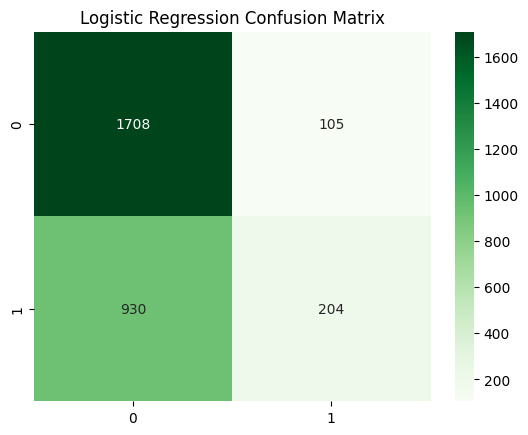

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_valid_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_log))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_log))

sns.heatmap(confusion_matrix(y_valid, y_pred_log), annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.show()


Balanced Logistic Regression Accuracy: 0.6437054631828979

Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.83      0.74      1813
        True       0.56      0.35      0.43      1134

    accuracy                           0.64      2947
   macro avg       0.61      0.59      0.59      2947
weighted avg       0.63      0.64      0.62      2947



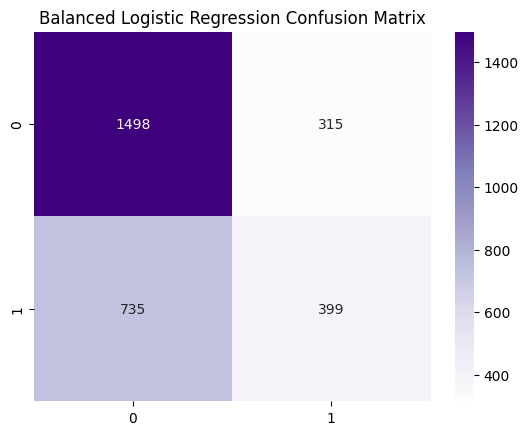

In [8]:
# Re-train logistic regression with class weights
log_reg_bal = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_bal.fit(X_train_scaled, y_train)

y_pred_bal = log_reg_bal.predict(X_valid_scaled)

print("Balanced Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_bal))

sns.heatmap(confusion_matrix(y_valid, y_pred_bal), annot=True, fmt='d', cmap='Purples')
plt.title("Balanced Logistic Regression Confusion Matrix")
plt.show()


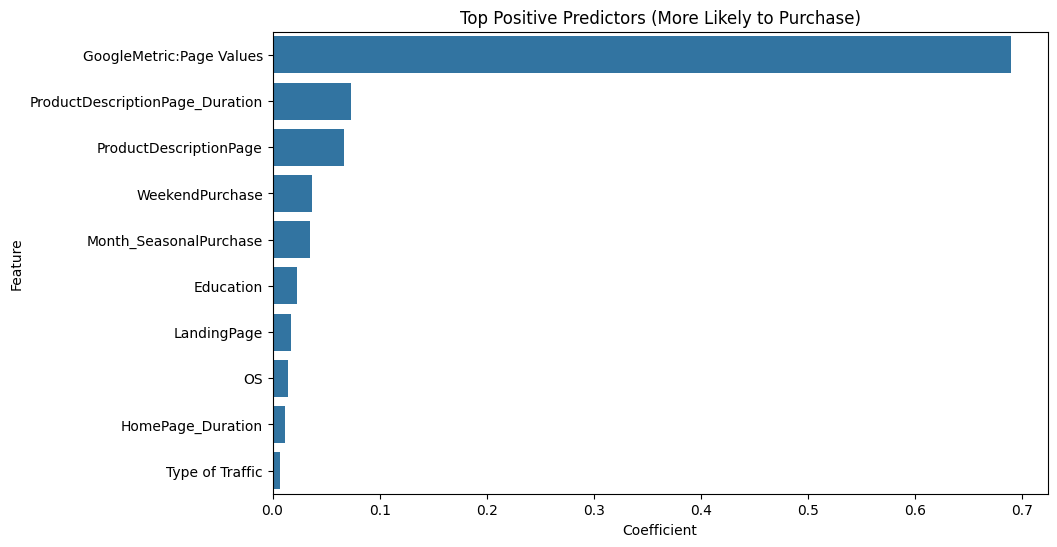

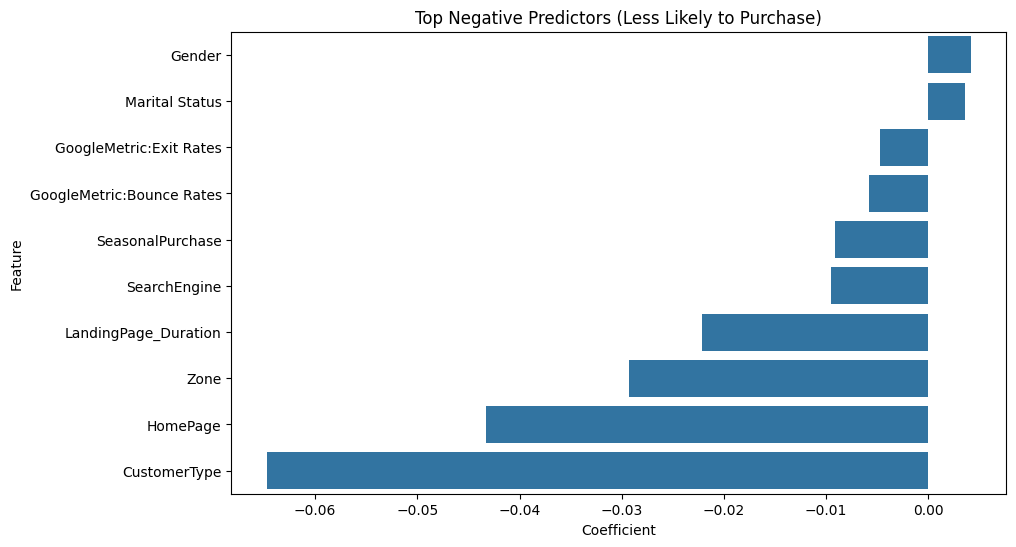

In [9]:
# Get and sort coefficients by absolute magnitude
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg_bal.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(10))
plt.title("Top Positive Predictors (More Likely to Purchase)")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.tail(10))
plt.title("Top Negative Predictors (Less Likely to Purchase)")
plt.show()


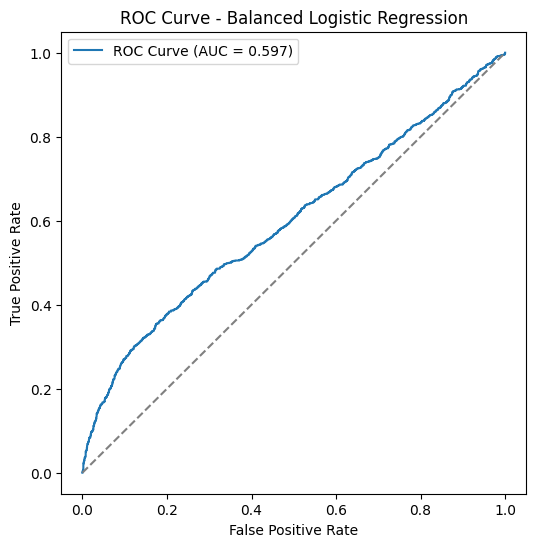

In [10]:
from sklearn.metrics import roc_curve, auc

y_proba = log_reg_bal.predict_proba(X_valid_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Balanced Logistic Regression')
plt.legend()
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder

# Make clean copies
train_simple = train_df.drop('Made_Purchase', axis=1).copy()
test_simple = test_df.copy()

# Fill missing values
for df in [train_simple, test_simple]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())

# Encode categorical columns safely
for col in train_simple.columns:
    if train_simple[col].dtype == 'object':
        le = LabelEncoder()
        combined_vals = pd.concat([train_simple[col].astype(str), test_simple[col].astype(str)], axis=0)
        le.fit(combined_vals)
        train_simple[col] = le.transform(train_simple[col].astype(str))
        test_simple[col] = le.transform(test_simple[col].astype(str))

# Make sure everything numeric
test_simple = test_simple.apply(pd.to_numeric, errors='coerce').fillna(0)

# Scale (using same scaler)
test_scaled = scaler.transform(test_simple)

# Predict with your best model
preds = log_reg_bal.predict(test_scaled)

print("Example output:")
print(preds[:20])
print("Shape:", preds.shape)


Example output:
[False False False False False False False False False False False False
 False False False False False False False False]
Shape: (6599,)


In [12]:
# Compute validation accuracies directly
knn_val_acc = accuracy_score(y_valid, y_pred_knn)
log_val_acc = accuracy_score(y_valid, y_pred_log)
log_bal_val_acc = accuracy_score(y_valid, y_pred_bal)

# Combine into a summary table
results = pd.DataFrame({
    "Model": ["KNN (k=20)", "Logistic Regression", "Balanced Logistic Regression"],
    "Validation Accuracy": [knn_val_acc, log_val_acc, log_bal_val_acc],
    "Notes": [
        "Good baseline, weak recall for True class",
        "Slightly higher accuracy, better precision",
        "Lower accuracy but recall for True roughly doubled"
    ]
})

print("\n=== Model Performance Summary ===\n")
display(results)



=== Model Performance Summary ===



,Model,Validation Accuracy,Notes
0,KNN (k=20),0.626060,"Good baseline, weak recall for True class"
1,Logistic Regression,0.648795,"Slightly higher accuracy, better precision"
2,Balanced Logistic Regression,0.643705,Lower accuracy but recall for True roughly dou...


C:\Users\moohu\AppData\Local\Temp\ipykernel_21140\825321461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="Validation Accuracy", palette="viridis")


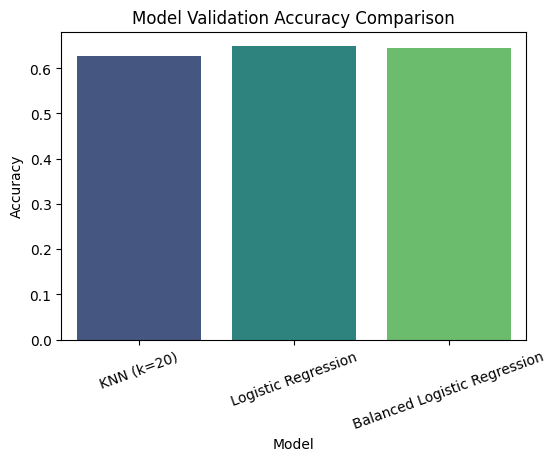

In [13]:
plt.figure(figsize=(6,4))
sns.barplot(data=results, x="Model", y="Validation Accuracy", palette="viridis")
plt.title("Model Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=20)
plt.show()
